In [1]:
import sys
sys.version
sys.version_info

sys.version_info(major=3, minor=6, micro=7, releaselevel='final', serial=0)

In [11]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
from keras.utils import to_categorical
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [0]:
ZIPPED_ORIGINAL = "/content/drive/My Drive/processedData.zip"
# ZIPPED_DATA = "/content/drive/My Drive/extendedData.zip"
# ZIPPED_KAGGLE = "/content/drive/My Drive/processed_kaggle.zip"
# ZIPPED_ORIGINAL_CV2 = "/content/drive/My Drive/preprocessed_CV2.zip"
# ZIPPED_KAGGLE_CV2 = "/content/drive/My Drive/processed_kaggle_CV2.zip"

In [0]:
import zipfile
with zipfile.ZipFile(ZIPPED_DATA,"r") as zip_ref:
    zip_ref.extractall("./data")
    zip_ref.close()

In [0]:
with zipfile.ZipFile(ZIPPED_KAGGLE, "r") as kagzip:
    kagzip.extractall("./data")
    kagzip.close()

In [0]:
with zipfile.ZipFile(ZIPPED_ORIGINAL, "r") as origzip:
    origzip.extractall("./data")
    origzip.close()

In [0]:
with zipfile.ZipFile(ZIPPED_ORIGINAL_CV2, "r") as origcv2zip:
    origcv2zip.extractall("./data")
    origcv2zip.close()

In [0]:
with zipfile.ZipFile(ZIPPED_KAGGLE_CV2, "r") as zipkagcv2:
    zipkagcv2.extractall("./data")
    zipkagcv2.close()

In [0]:
TRAIN_LAB_PATH = "./data/extendedTrainLabels.csv" # "./data/train_labels.csv"
PREPROCESSED_TRAINING = "./data/extendedTrainData.npy" # "./data/processedData.npy"
PREPROCESSED_KAGGLE = "./data/processed_kaggle.npy"
PREPROCESSED_KAGGLE_CV2 = "./data/processed_kaggle_CV2.npy"
PREPROCESSED_ORIGINAL = "./data/processedData.npy"
PREPROCESSED_ORIGINAL_CV2 = "./data/preprocessed_CV2.npy"
ORIG_LAB_PATH = "/content/drive/My Drive/train_labels.csv"

In [0]:
CATEGORIES = ['apple', 'empty', 'moustache', 'mouth', 'mug', 'nail', 'nose', 'octagon', 'paintbrush', 'panda', 'parrot', 'peanut', 'pear', 'pencil', 'penguin', 'pillow', 'pineapple', 'pool', 'rabbit', 'rhinoceros', 'rifle', 'rollerskates', 'sailboat', 'scorpion', 'screwdriver', 'shovel', 'sink', 'skateboard', 'skull', 'spoon', 'squiggle']

def getIndexOf(category):
    return CATEGORIES.index(category)

def getCategoryOf(index):
    return CATEGORIES[index]

def load(infile):
    unformatted_images = np.load(infile, encoding='bytes')
    formatted = []
    for i,img in enumerate(unformatted_images):
        formatted.append([i, img[0]])
    return formatted

def formatXData(X, xDimension = 40):
    X = np.asarray(X)
    # Convert to matrix form
    X = X.reshape(-1, xDimension, xDimension, 1)
    # Convert to float
    X = X.astype('float32')
    # Scale pixel values between 0 and 1
    X = X / 255
    return X.astype('float32')

def addRotations(X,y):
    newX = []
    newY = []
    for i,XMatrix in enumerate(X):
        newX.append(XMatrix)
        newY.append(y[i])
        newX.append(np.rot90(XMatrix, 1))
        newY.append(y[i])
        newX.append(np.rot90(XMatrix, 2))
        newY.append(y[i])
        newX.append(np.rot90(XMatrix, 3))
        newY.append(y[i])
    return np.asarray(newX),np.asarray(newY)

def formatData(images, labels, xDimension = 40, onehot=False):
    if not onehot:
        categories = list(set(labels['Category']))
        X = []
        y = []
        for i, img in enumerate(images):
            label = labels.at[i,'Category']
            categoryNum = getIndexOf(label)
            X.append(img[1])
            y.append(categoryNum)
        y = to_categorical(y)
        X = formatXData(X, xDimension)
    else:
        X = []
        y = labels
        for i, img in enumerate(images):
            X.append(img[1])
        X = formatXData(X, xDimension)
    return X.astype('float32'), y

def split(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1)
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=1) 
    return X_train, y_train, X_test, y_test, X_val, y_val

In [0]:
def visualizePredictions(images, predictions, indices, shape=(40, 40)):
    fig, ax = plt.subplots(figsize=(len(CATEGORIES) + 1, len(indices) * 3))

    for spot, i in enumerate(indices):

        # plot probabilities:
        ax = plt.subplot2grid((len(indices), 5), (spot, 0), colspan=4);
        plt.bar(np.arange(len(CATEGORIES)), predictions[i], 0.35, align='center');
        plt.xticks(np.arange(len(CATEGORIES)), CATEGORIES)
        plt.tick_params(axis='x', bottom='off', top='off')
        plt.ylabel('Probability')
        plt.ylim(0,1)
        plt.subplots_adjust(hspace = 0.5)

        # plot picture:
        ax = plt.subplot2grid((len(indices), 5), (spot, 4));
        plt.imshow(images[i].reshape(shape),cmap='gray_r', interpolation='nearest');
        plt.xlabel(getCategoryOf(np.argmax(predictions[i]))); # get the label from the dict
        plt.xticks([])
        plt.yticks([])

def visualizePredictionsJustWrong(images, predictions, actual, start = 0, end = 10, shape=(40, 40)):
    fig, ax = plt.subplots(figsize=(len(CATEGORIES) + 1, 30))
    numFound = 0
    for i in range(start, len(images)):
        if getCategoryOf(np.argmax(predictions[i])) != getCategoryOf(np.argmax(actual[i])):
            # plot probabilities:
            ax = plt.subplot2grid((end - start, 5), (numFound, 0), colspan=4);
            plt.bar(np.arange(len(CATEGORIES)), predictions[i], 0.35, align='center');
            plt.xticks(np.arange(len(CATEGORIES)), CATEGORIES)
            plt.tick_params(axis='x', bottom='off', top='off')
            plt.ylabel('Probability')
            plt.ylim(0,1)
            plt.subplots_adjust(hspace = 0.5)

            # plot picture:
            ax = plt.subplot2grid((end - start, 5), (numFound, 4));
            plt.imshow(images[i].reshape(shape),cmap='gray_r', interpolation='nearest');
            plt.xlabel(str(i) + ":" +getCategoryOf(np.argmax(predictions[i])) + "/" +getCategoryOf(np.argmax(actual[i]))); # get the label from the dict
            plt.xticks([])
            plt.yticks([])
            
            numFound += 1
            if numFound >= end - start:
                return


In [0]:
training_imgs = load(PREPROCESSED_TRAINING)

In [0]:
labels = np.genfromtxt(TRAIN_LAB_PATH, skip_header=0)

In [0]:
origs_img = []
origs_lab = []
labels = labels.tolist()
idx = int(len(training_imgs)/60)
for i in range(0, idx):
    j = 60*i - i
    origs_img.append(training_imgs.pop(j))
    origs_lab.append(labels.pop(j))
    
labels = np.array(labels)
origs_lab = np.array(origs_lab)

In [0]:
orig_imgs = load(PREPROCESSED_ORIGINAL)
orig_labels = pd.read_csv(ORIG_LAB_PATH)
orig_X, orig_labels = formatData(orig_imgs, orig_labels, onehot=False)

In [0]:
X,y = formatData(training_imgs, labels, onehot=True)
X_val, y_val = formatData(origs_img, origs_lab, onehot=True)

In [0]:
del training_imgs
del labels

In [13]:
import gc
gc.collect()

0

In [0]:
# X_train, y_train, X_test, y_test, X_val, y_val = split(X,y)

In [0]:
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Activation, ZeroPadding2D
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from sklearn.ensemble import RandomForestClassifier
from keras import regularizers

In [0]:
import csv
import matplotlib.pyplot as plt
import time

In [0]:
batch_size = 128
epochs = 40
num_classes = len(CATEGORIES)

In [0]:
def plotHistory(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

def loadModel(path):
  return load_model(path)

def createModel(input_shape=(40, 40, 1)):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 kernel_initializer='he_normal',
                 input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
#     model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(Dropout(0.4))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
    model.summary()
    return model

def createModel2(input_shape=(40, 40, 1)):
        # INPUT -> [CONV -> RELU -> CONV -> RELU -> POOL]*3 -> [FC -> RELU]*2 -> FC
    model = Sequential()
    #Input
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     kernel_initializer='he_normal',
                     input_shape=input_shape))
    
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
#     model.add(Dense(256, activation='relu'))
#     model.add(Dense(256, activation='relu'))
    model.add(Dense(256, kernel_regularizer=keras.regularizers.l2(0.3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(256, kernel_regularizer=keras.regularizers.l2(0.2)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
    model.summary()
    return model

def createModelWithPadding(input_shape=(40, 40, 1)):
    model = Sequential()
    model.add(ZeroPadding2D(padding=(1, 1), input_shape=input_shape))
    model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 kernel_initializer='he_normal'))

#     model.add(MaxPooling2D((2, 2)))
#     model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(Dropout(0.4))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
    model.summary()
    return model

In [0]:
def createModelWithPaddingAndMoreLayers(input_shape=(40, 40, 1)):
    model = Sequential()
    model.add(ZeroPadding2D(padding=(1, 1), input_shape=input_shape))
    model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 kernel_initializer='he_normal'))

    model.add(MaxPooling2D((2, 2)))
#     model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(Dropout(0.4))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
    model.summary()
    return model


In [0]:
def savePredictions(outfile, predictions):
    if outfile == '':
        for i, prediction in enumerate(predictions):
            index = np.argmax(prediction)
            print(i,getCategoryOf(index))
    else:
        with open(outfile,'w') as csvfile:
            fieldnames = ['Id', 'Category']
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writeheader()
            for i, prediction in enumerate(predictions):
                index = np.argmax(prediction)
                writer.writerow({'Id': i, 'Category': getCategoryOf(index)})

In [0]:
model2 = createModelWithPaddingAndMoreLayers()
history = model2.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_val, y_val))
score = model2.evaluate(X_test, y_test, verbose=0)

In [0]:
score

In [0]:
preprocessed_kaggle = load(PREPROCESSED_KAGGLE)
X_kaggle = formatXData(list(map(lambda x: x[1], preprocessed_kaggle)))
# kaggle_predictions = model2.predict(X_kaggle)

In [0]:
savePredictions('./prediction_11_20_3.csv',kaggle_predictions)

In [0]:
# We want to continue training
plotHistory(history)


In [0]:
# train for another 40 epochs
history = model2.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_val, y_val))
score = model2.evaluate(X_test, y_test, verbose=0)

In [0]:
plotHistory(history)

In [0]:
score

[1.0411031639575958, 0.74475]

In [0]:
preprocessed_kaggle = load(PREPROCESSED_KAGGLE)
X_kaggle = formatXData(list(map(lambda x: x[1], preprocessed_kaggle)))
kaggle_predictions = model2.predict(X_kaggle)

In [0]:
savePredictions('./prediction_11_20_4.csv',kaggle_predictions)

In [0]:
model2.save('./createModelWithPaddingAndMoreLayers_80epochs.h5')  # creates a HDF5 file 'my_model.h5'

In [0]:
# RUN IT AGAIN!!!!
history = model2.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_val, y_val))
score = model2.evaluate(X_test, y_test, verbose=0)

In [0]:
score

In [0]:
plotHistory(history)

In [0]:
preprocessed_kaggle = load(PREPROCESSED_KAGGLE)
X_kaggle = formatXData(list(map(lambda x: x[1], preprocessed_kaggle)))
kaggle_predictions = model2.predict(X_kaggle)
savePredictions('./prediction_11_20_5.csv',kaggle_predictions)
model2.save('./createModelWithPaddingAndMoreLayers_120epochs.h5')  # creates a HDF5 file 'my_model.h5'

In [0]:
# AND AGAIN!!!!!
history = model2.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_val, y_val))
score = model2.evaluate(X_test, y_test, verbose=0)

In [0]:
score

[1.0969892027378083, 0.7545]

In [0]:
plotHistory(history)

In [0]:
preprocessed_kaggle = load(PREPROCESSED_KAGGLE)
X_kaggle = formatXData(list(map(lambda x: x[1], preprocessed_kaggle)))
kaggle_predictions = model2.predict(X_kaggle)
savePredictions('./prediction_11_20_6.csv',kaggle_predictions)
model2.save('./createModelWithPaddingAndMoreLayers_160epochs.h5')  # creates a HDF5 file 'my_model.h5'

In [0]:
visualizePredictions(X_kaggle, kaggle_predictions, range(1050,1070))

In [0]:
def modelWithEvenMoreLayers(input_shape=(40, 40, 1)):
    model = Sequential()
    model.add(ZeroPadding2D(padding=(3, 3), input_shape=input_shape))
    model.add(Conv2D(32, kernel_size=(5, 5),
                 activation='relu',
                 kernel_initializer='he_normal'))

    model.add(MaxPooling2D((2, 2)))
#     model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(Dropout(0.4))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
    model.summary()
    return model


In [0]:
model3 = modelWithEvenMoreLayers()

In [0]:
history = model3.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_val, y_val))
score = model3.evaluate(X_test, y_test, verbose=0)

In [0]:
score

[1.0578505320549012, 0.72875]

In [0]:
import os
os.mkdir('./modelWithEvenMoreLayers')

In [0]:
plotHistory(history)

In [0]:
preprocessed_kaggle = load(PREPROCESSED_KAGGLE)
X_kaggle = formatXData(list(map(lambda x: x[1], preprocessed_kaggle)))
kaggle_predictions = model3.predict(X_kaggle)
savePredictions('./modelWithEvenMoreLayers/prediction_11_20_1.csv',kaggle_predictions)
model3.save('./modelWithEvenMoreLayers/createModelWithPaddingAndMoreLayers_40epochs.h5')  # creates a HDF5 file 'my_model.h5'

In [0]:
history = model3.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_val, y_val))
score = model3.evaluate(X_test, y_test, verbose=0)

In [0]:
score

[1.1596479260921477, 0.748]

In [0]:
plotHistory(history)

In [0]:
preprocessed_kaggle = load(PREPROCESSED_KAGGLE)
X_kaggle = formatXData(list(map(lambda x: x[1], preprocessed_kaggle)))
kaggle_predictions = model3.predict(X_kaggle)
savePredictions('./modelWithEvenMoreLayers/prediction_11_20_2.csv',kaggle_predictions)
model3.save('./modelWithEvenMoreLayers/createModelWithPaddingAndMoreLayers_80epochs.h5')  # creates a HDF5 file 'my_model.h5'

In [0]:
def morePadding(input_shape=(40, 40, 1)):
    model = Sequential()
    model.add(ZeroPadding2D(padding=(1, 1), input_shape=input_shape))
    model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 kernel_initializer='he_normal'))

    model.add(MaxPooling2D((2, 2)))
#     model.add(Dropout(0.25))
    model.add(ZeroPadding2D(padding=(1, 1)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(ZeroPadding2D(padding=(1, 1)))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D(padding=(1, 1)))
    model.add(Dropout(0.4))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
    model.summary()
    return model

In [0]:
morePadding()

## Yves' model + morePadding + saving/loading models/predictions

In [0]:
def yvesModel(input_shape=(40,40,1), optimizer='adam'):
    model = Sequential()
    model.add(ZeroPadding2D(padding=(3, 3), input_shape=input_shape))
    model.add(Conv2D(64, kernel_size=(7, 7),
                 activation='relu',
                 kernel_initializer='he_normal'))
    model.add(BatchNormalization()) # Added to Adam2
#     model.add(Dropout(0.25)) # Added to Adam2
    
    model.add(ZeroPadding2D(padding=(2, 2)))
    model.add(Conv2D(128, kernel_size=(5, 5), # Used to be 128 filters
                 activation='relu',
                 kernel_initializer='he_normal'))
    model.add(BatchNormalization()) # Added to Adam2
#     model.add(Dropout(0.4)) # Added to Adam2
    
    model.add(Conv2D(256, kernel_size=(3, 3),# Used to be 128 filters
                 activation='relu',
                 kernel_initializer='he_normal'))
    model.add(BatchNormalization())
#     model.add(Dropout(0.4)) # Added to Adam2
    
    model.add(GlobalMaxPooling2D())#pool_size=(2, 2)))
#     model.add(Flatten())
    model.add(Dense(512, activation='relu'))# Used to be 512 neurons
#     model.add(BatchNormalization()) # Added to Adam2
    model.add(Dropout(0.5))
    
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=optimizer,#keras.optimizers.Adadelta(),
              metrics=['accuracy'])
    model.summary()
    return model

In [0]:
yvesModel()

In [0]:
modelYvesAdam2 = yvesModel(optimizer='adam') # Adam ended up better!
history = modelYvesAdam2.fit(X, y,
          batch_size=128,
          epochs=10,
          verbose=1,
          validation_data=(X_val, y_val))
modelYvesAdam2.save('/content/drive/My Drive/modelYvesAdam2-10epochs.h5')

In [0]:
modelYvesAdam2 = load_model('/content/drive/My Drive/modelYvesAdam2-extra-training.h5')

In [0]:
# Extra training!
history = modelYvesAdam2.fit(X, y,
          batch_size=batch_size,
          epochs=10,
          verbose=1,
          validation_data=(X_val, y_val))

preprocessed_kaggle = load(PREPROCESSED_KAGGLE)
X_kaggle = formatXData(list(map(lambda x: x[1], preprocessed_kaggle)))
kaggle_predictions = modelYvesAdam2.predict(X_kaggle)
savePredictions('/content/drive/My Drive/modelYvesAdam2-extra-training.csv',kaggle_predictions)
modelYvesAdam2.save('/content/drive/My Drive/modelYvesAdam2-extra-training.h5')  # creates a HDF5 file 'my_model.h5'

In [0]:
modelYvesAdam = yvesModel(optimizer='adam')
history = modelYvesAdam.fit(X, y,
          batch_size=batch_size,
          epochs=10,
          verbose=1,
          validation_data=(X_val, y_val))
modelYvesAdam.save('/content/drive/My Drive/modelYvesAdam-10epochs.h5')

In [0]:
modelYvesAdam = load_model('/content/drive/My Drive/modelYvesAdam-10epochs.h5')

In [0]:
# Extra training!
history = modelYvesAdam.fit(X, y,
          batch_size=batch_size,
          epochs=10,
          verbose=1,
          validation_data=None)

preprocessed_kaggle = load(PREPROCESSED_KAGGLE)
X_kaggle = formatXData(list(map(lambda x: x[1], preprocessed_kaggle)))
kaggle_predictions = modelYvesAdam.predict(X_kaggle)
savePredictions('/content/drive/My Drive/modelYvesAdam-extra-training.csv',kaggle_predictions)
modelYvesAdam.save('/content/drive/My Drive/modelYvesAdam-extra-training.h5')  # creates a HDF5 file 'my_model.h5'

## Model4

In [0]:
model4 = morePadding()
history = model4.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=10,
          verbose=1,
          validation_data=(X_val, y_val))
score = model4.evaluate(X_test, y_test, verbose=0)

In [0]:
model4.save('/content/drive/My Drive/model-4-extended-10epochs-split.h5')

In [0]:
model4 = load_model('/content/drive/My Drive/model4-extend-extra-training.h5')

In [0]:
# TRAIN MODEL4 AGAIN!
history = model4.fit(X, y,
          batch_size=batch_size,
          epochs=10,
          verbose=1,
          validation_data=None)
score = model4.evaluate(X_test, y_test, verbose=0)
print(score)
score = model4.evaluate(orig_X, orig_Y)
print(score)

preprocessed_kaggle = load(PREPROCESSED_KAGGLE)
X_kaggle = formatXData(list(map(lambda x: x[1], preprocessed_kaggle)))
kaggle_predictions = model4.predict(X_kaggle)
savePredictions('/content/drive/My Drive/model4-extend-extra-training.csv',kaggle_predictions)
model4.save('/content/drive/My Drive/model4-extend-extra-training.h5')  # creates a HDF5 file 'my_model.h5'

In [0]:
model4.save('/content/drive/My Drive/model4-extend-extra-training.h5')  # creates a HDF5 file 'my_model.h5'

In [0]:
score = model4.evaluate(orig_X, orig_Y)
score

In [0]:
savePredictions('./model4-extend-extra-training.csv',kaggle_predictions)

In [0]:
plotHistory(history)

In [0]:
import os
os.mkdir('./morePadding')

In [0]:
preprocessed_kaggle = load(PREPROCESSED_KAGGLE)
X_kaggle = formatXData(list(map(lambda x: x[1], preprocessed_kaggle)))
kaggle_predictions = model4.predict(X_kaggle)
savePredictions('./morePadding/120_epochs.csv',kaggle_predictions)
model4.save('./morePadding/120_epochs.h5')  # creates a HDF5 file 'my_model.h5'

In [0]:
model4 = loadModel('./morePadding/120_epochs.h5')

In [0]:
from keras import backend as K
from keras.preprocessing.image import save_img
import numpy as np
import time

def convertImg(img):
    img = [row[0] for row in img]
    newImg = [[[col] for col in row] for row in img]
    return np.asarray(newImg)
  
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x
def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + K.epsilon())

def getFilterVisualization(model, layer_name = 'conv2d_14', img_width = 10, img_height = 10, total_filters = 100):
    layer_dict = dict([(layer.name, layer) for layer in model.layers])
    print(layer_dict.keys())
    input_img = model.input
    layer_output = layer_dict[layer_name].output
    kept_filters = []

    for filter_index in range(total_filters):
        print('Processing filter %d' % filter_index)
        start_time = time.time()

        # we build a loss function that maximizes the activation
        # of the nth filter of the layer considered
        layer_output = layer_dict[layer_name].output
        if K.image_data_format() == 'channels_first':
            loss = K.mean(layer_output[:, filter_index, :, :])
        else:
            loss = K.mean(layer_output[:, :, :, filter_index])

        # we compute the gradient of the input picture wrt this loss
        grads = K.gradients(loss, input_img)[0]

        # normalization trick: we normalize the gradient
        grads = normalize(grads)

        # this function returns the loss and grads given the input picture
        iterate = K.function([input_img], [loss, grads])

        # step size for gradient ascent
        step = 1.

        # we start from a gray image with some random noise
        if K.image_data_format() == 'channels_first':
            input_img_data = np.random.random((1, 1, img_width, img_height))
        else:
            input_img_data = np.random.random((1, img_width, img_height, 1))
        input_img_data = (input_img_data - 0.5) * 20 + 128

        # we run gradient ascent for 20 steps
        for i in range(20):
            loss_value, grads_value = iterate([input_img_data])
            input_img_data += grads_value * step

            #print('Current loss value:', loss_value)
            if loss_value <= 0.:
                # some filters get stuck to 0, we can skip them
                break

        # decode the resulting input image
        if loss_value > 0:
            img = deprocess_image(input_img_data[0])
            kept_filters.append((img, loss_value))
        end_time = time.time()
        print('Filter %d processed in %ds' % (filter_index, end_time - start_time))
    
    # want to have a number that can be squared and be less than the total number of kept filters. Or 8.
    n = math.min(8,int(math.log(len(kept_filters), 2)))

    # the filters that have the highest loss are assumed to be better-looking.
    # we will only keep the top 64 filters.
    kept_filters.sort(key=lambda x: x[1], reverse=True)
    kept_filters = kept_filters[:n * n]

    # build a black picture with enough space for
    # our 8 x 8 filters of size 128 x 128, with a 5px margin in between
    margin = 5
    width = n * img_width + (n - 1) * margin
    height = n * img_height + (n - 1) * margin
    stitched_filters = np.zeros((width, height, 1))

    # fill the picture with our saved filters
    for i in range(n):
        for j in range(n):
            img, loss = kept_filters[i * n + j]
            width_margin = (img_width + margin) * i
            height_margin = (img_height + margin) * j
            stitched_filters[
                width_margin: width_margin + img_width,
                height_margin: height_margin + img_height, :] = convertImg(img)

    # save the result to disk
    save_img('stitched_filters_%dx%d.png' % (n, n), stitched_filters)


In [0]:
getFilterVisualization(model4, 'conv2d_15', 3, 3)

In [0]:
def paddingAndNormalization(input_shape=(40, 40, 1)):
    model = Sequential()
    model.add(ZeroPadding2D(padding=(1, 1), input_shape=input_shape))
    model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 kernel_initializer='he_normal'))

    model.add(MaxPooling2D((2, 2)))
#     model.add(Dropout(0.25))
    model.add(ZeroPadding2D(padding=(1, 1)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(ZeroPadding2D(padding=(1, 1)))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(ZeroPadding2D(padding=(1, 1)))
    model.add(Dropout(0.4))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
    model.summary()
    return model

In [0]:
model5 = paddingAndNormalization()

In [0]:
history = model5.fit(X, y,
          batch_size=batch_size,
          epochs=10,
          verbose=1,
          validation_data=(X_val, y_val))
model5.save('/content/drive/My Drive/model5-10epochs.h5')

In [0]:
model5 = load_model('/content/drive/My Drive/model5-10k-extra-training.h5')

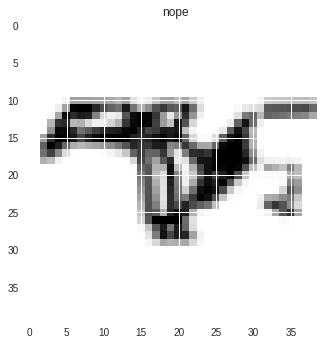

In [91]:
plt.imshow(X_kaggle_CV2[113].reshape(40,40))
plt.title("nope")
plt.show()

In [0]:
losses = []
accs = []

In [0]:
accs = np.loadtxt('/content/drive/My Drive/model5acc.txt').tolist()
losses = np.loadtxt('/content/drive/My Drive/model5loss.txt').tolist()

In [0]:
min = 0
max = 10
fig, (ax1, ax2) = plt.subplots(max-min,2)

for i in range(0,len(kagpred)):
    lb = np.array(kagpred[i])
    lbcv2 = np.array(kagcv2pred[i])
    lb = CATEGORIES[np.argmax(lb)]
    lbcv2 = CATEGORIES[np.argmax(lbcv2)]
    numDiff = 0
    if lb != lbcv2 and numDiff >= min and numDiff < 10:
        ax1.imshow(X_kaggle[i].reshape(40,40))
        ax2.imshow(X_kaggle_CV2[i].reshape(40,40))
        fig.title = lb + " " + lbcv2
        fig.show()
        numDiff += 1
    elif lb != lbcv2 and numDiff < min:
        numDiff += 1
    elif lb != lbcv2:
        break

In [97]:
history = model5.fit(X, y,
          batch_size=batch_size,
          epochs=5,
          verbose=1)#,
#           validation_data=(X_val, y_val))

losses.extend(history.history['loss'])
accs.extend(history.history['acc'])

history = model5.fit(X_val, y_val,
          batch_size=batch_size,
          epochs=3,
          verbose=1)

losses.extend(history.history['loss'])
accs.extend(history.history['acc'])

history = model5.fit(origCV2_X, y_val,
          batch_size=batch_size,
          epochs=3,
          verbose=1)

losses.extend(history.history['loss'])
accs.extend(history.history['acc'])

preprocessed_kaggle = load(PREPROCESSED_KAGGLE)
X_kaggle = formatXData(list(map(lambda x: x[1], preprocessed_kaggle)))
kaggle_predictions = model5.predict(X_kaggle)
savePredictions('/content/drive/My Drive/model5-10k-extra-training.csv',kaggle_predictions)
model5.save('/content/drive/My Drive/model5-10k-extra-training.h5')  # creates a HDF5 file 'my_model.h5'

Epoch 1/5
590000/590000 [==============================] - 358s 607us/step - loss: 0.4518 - acc: 0.8510
Epoch 2/5
590000/590000 [==============================] - 356s 604us/step - loss: 0.4466 - acc: 0.8531
Epoch 3/5
590000/590000 [==============================] - 357s 605us/step - loss: 0.4454 - acc: 0.8531
Epoch 4/5
590000/590000 [==============================] - 357s 605us/step - loss: 0.4447 - acc: 0.8530
Epoch 5/5
590000/590000 [==============================] - 356s 604us/step - loss: 0.4444 - acc: 0.8526
Epoch 1/3
10000/10000 [==============================] - 6s 615us/step - loss: 0.4780 - acc: 0.8459
Epoch 2/3
10000/10000 [==============================] - 6s 605us/step - loss: 0.4015 - acc: 0.8667
Epoch 3/3
10000/10000 [==============================] - 6s 605us/step - loss: 0.3729 - acc: 0.8734
Epoch 1/3
10000/10000 [==============================] - 6s 606us/step - loss: 0.6005 - acc: 0.8315
Epoch 2/3
10000/10000 [==============================] - 6s 607us/step - loss: 0

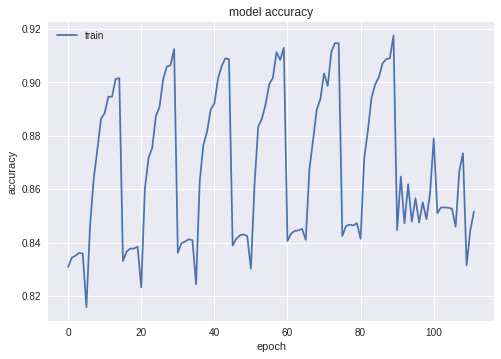

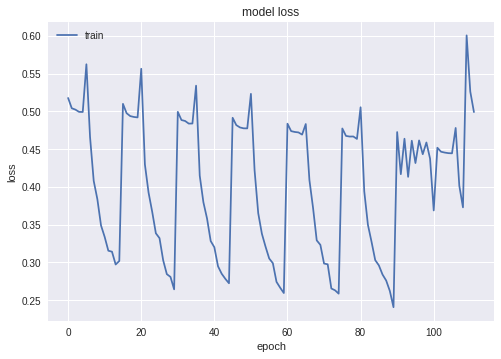

In [115]:
# summarize history for accs
plt.plot(accs)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(losses)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [0]:
good_acc = losses[:101]
good_loss = accs[:101]

In [0]:
good_acc.extend(accs[101:])
good_loss.extend(losses[101:])

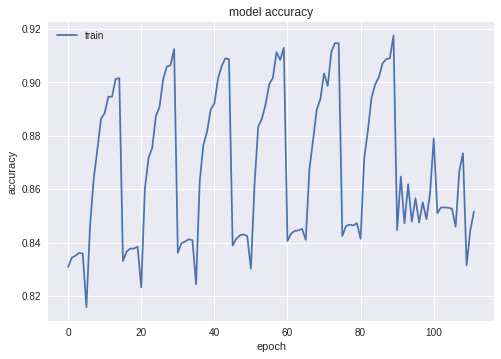

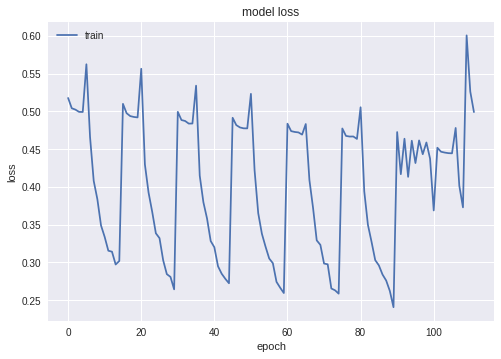

In [113]:
# summarize history for accs
plt.plot(good_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(good_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()


np.savetxt('/content/drive/My Drive/model5acc.txt', good_acc)
np.savetxt('/content/drive/My Drive/model5loss.txt', good_loss)

In [0]:
model5Old = load_model('/content/drive/My Drive/model5-extra-training.h5')

In [117]:
history = model5Old.fit(X_val, y_val,
          batch_size=batch_size,
          epochs=10,
          verbose=1)
model5Old.save('/content/drive/My Drive/model5-40ep-10k-Replica.h5')

Epoch 1/10
10000/10000 [==============================] - 7s 711us/step - loss: 0.6818 - acc: 0.7841
Epoch 2/10
10000/10000 [==============================] - 6s 608us/step - loss: 0.5250 - acc: 0.8314
Epoch 3/10
10000/10000 [==============================] - 6s 604us/step - loss: 0.4711 - acc: 0.8466
Epoch 4/10
10000/10000 [==============================] - 6s 605us/step - loss: 0.4391 - acc: 0.8577
Epoch 5/10
10000/10000 [==============================] - 6s 606us/step - loss: 0.4064 - acc: 0.8682
Epoch 6/10
10000/10000 [==============================] - 6s 607us/step - loss: 0.3878 - acc: 0.8710
Epoch 7/10
10000/10000 [==============================] - 6s 605us/step - loss: 0.3752 - acc: 0.8811
Epoch 8/10
10000/10000 [==============================] - 6s 606us/step - loss: 0.3452 - acc: 0.8912
Epoch 9/10
10000/10000 [==============================] - 6s 607us/step - loss: 0.3450 - acc: 0.8880
Epoch 10/10
10000/10000 [==============================] - 6s 605us/step - loss: 0.3283 - a

In [0]:
predtest = model5Old.predict(X_kaggle)
savePredictions("replica_pred.csv", predtest)

In [0]:
from functools import reduce
lowConfidence = np.nonzero(list(map((lambda x: 1 if np.max(x)<0.2 else 0), kaggle_predictions)))[0]

In [0]:
lowConfidence

In [0]:
visualizePredictions(X_kaggle, kaggle_predictions, lowConfidence)